In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(style="whitegrid")
%matplotlib inline

In [3]:
base_path = '/Users/rad/Desktop/Useable Ai Project /Datasets/'

In [4]:
drivers = pd.read_csv(os.path.join(base_path, 'drivers.csv'))
constructors = pd.read_csv(os.path.join(base_path, 'constructors.csv'))
races = pd.read_csv(os.path.join(base_path, 'races.csv'))
results = pd.read_csv(os.path.join(base_path, 'results.csv'))
lap_times = pd.read_csv(os.path.join(base_path, 'lap_times.csv'))
pit_stops = pd.read_csv(os.path.join(base_path, 'pit_stops.csv'))
qualifying = pd.read_csv(os.path.join(base_path, 'qualifying.csv'))
circuits = pd.read_csv(os.path.join(base_path, 'circuits.csv'))

<h2> Data Preprocessing</h2>

In [5]:
print(drivers.info())
print(drivers.describe(include='all'))

print(results.info())
print(results.describe())

print(pit_stops.info())
print(pit_stops.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   driverId     861 non-null    int64 
 1   driverRef    861 non-null    object
 2   number       861 non-null    object
 3   code         861 non-null    object
 4   forename     861 non-null    object
 5   surname      861 non-null    object
 6   dob          861 non-null    object
 7   nationality  861 non-null    object
 8   url          861 non-null    object
dtypes: int64(1), object(8)
memory usage: 60.7+ KB
None
          driverId driverRef number code forename surname         dob  \
count   861.000000       861    861  861      861     861         861   
unique         NaN       861     49   98      478     802         843   
top            NaN  hamilton     \N   \N     John  Taylor  1919-10-28   
freq           NaN         1    802  757       14       5           2   
mean    431.061556      

<h4>Merging Core Tables into One DataFrame</h4>

In [7]:
merged_df = results.merge(races, on='raceId', how='left')
merged_df = merged_df.merge(drivers, on='driverId', how='left')
merged_df = merged_df.merge(constructors, on='constructorId', how='left')

In [8]:
# Droping unnecessary columns 
circuits_clean = circuits.drop(columns=['url'])  # or drop other unneeded fields
merged_df = merged_df.merge(circuits_clean, on='circuitId', how='left')

<h4>Checking for Missing Values</h4>

In [9]:
missing_values = merged_df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:")
print(missing_values[missing_values > 0])

Missing values per column:
Series([], dtype: int64)


<h4>Checking for Duplicate Rows</h4>

In [10]:
duplicate_count = merged_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


<h4>Identified Invalid Data (e.g., Negative Lap Times)</h4>

In [11]:
negative_laps = lap_times[lap_times['milliseconds'] < 0]
print(f"Negative lap time entries: {len(negative_laps)}")
print(negative_laps.head())

Negative lap time entries: 0
Empty DataFrame
Columns: [raceId, driverId, lap, position, time, milliseconds]
Index: []


<h2>Exploratory Data Analysis (EDA)</h2>

<h4>Distribution: Number of Drivers per Constructor</h4>

In [13]:
drivers_per_team = merged_df.groupby('name_y')['driverId'].nunique().sort_values(ascending=False)
print(drivers_per_team.head(10))

name_y
Ferrari          98
Maserati         92
Kurtis Kraft     87
BRM              70
Williams         62
Team Lotus       61
Cooper-Climax    58
McLaren          55
Lotus-Climax     55
Brabham          49
Name: driverId, dtype: int64


To see which teams have had the most drivers — helps understand team strategies or turnover rate.

<h4>Race Count per Year</h4>

In [15]:
race_count_per_year = merged_df[['raceId', 'year']].drop_duplicates().groupby('year').count()
print(race_count_per_year.tail(10))

      raceId
year        
2015      19
2016      21
2017      20
2018      21
2019      21
2020      17
2021      22
2022      22
2023      22
2024      24


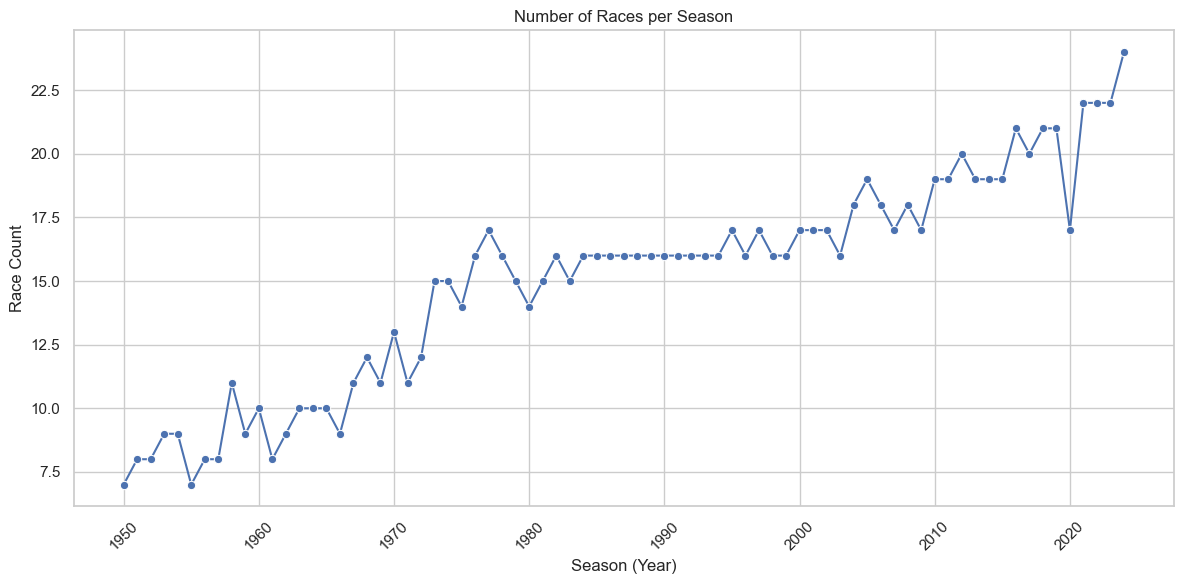

In [34]:
if 'year' in races.columns:
    races_per_season = races.groupby('year')['raceId'].count().reset_index()
    races_per_season.rename(columns={'raceId': 'Number of Races'}, inplace=True)

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=races_per_season, x='year', y='Number of Races', marker='o')
    plt.title('Number of Races per Season')
    plt.xlabel('Season (Year)')
    plt.ylabel('Race Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("The 'races' dataset does not contain a 'year' column.")

-  **Steady Growth**: Races increased from ~7 in the 1950s to 23 in recent years, showing F1's global expansion.  
-  **Milestone Trends**: Race count surpassed 10 by the 1970s, stabilized in the 80s–90s, and rose sharply post-2010.  
-  **Recent Peak**: Despite a 2020 dip (COVID-19), race numbers hit a record high after 2021.

 <h4>Grid Position vs Final Position</h4>

In [16]:
# Correlation and relationship between starting and ending position
grid_vs_final = merged_df[['grid', 'positionOrder']].dropna()
correlation = grid_vs_final.corr()
print("Correlation:\n", correlation)

Correlation:
                    grid  positionOrder
grid           1.000000       0.165097
positionOrder  0.165097       1.000000


A correlation close to 1 would mean grid position heavily predicts the outcome, but 0.165 suggests many drivers improve or worsen significantly from their starting spot.

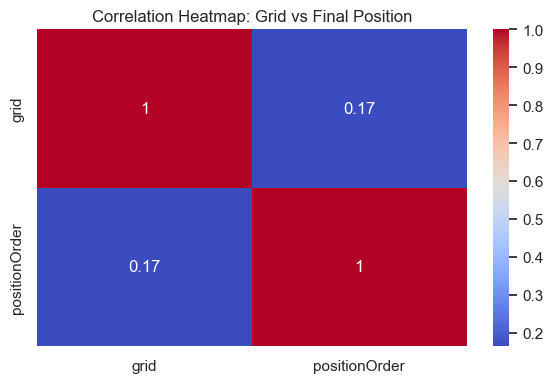

In [25]:
plt.figure(figsize=(6, 4))
sns.heatmap(merged_df[['grid', 'positionOrder']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: Grid vs Final Position')
plt.tight_layout()
plt.show()

 <h4>Distribution of Grid Positions</h4>

In [17]:
grid_distribution = merged_df['grid'].value_counts().sort_index()
print(grid_distribution.head(10))

grid
0    1638
1    1136
2    1125
3    1130
4    1132
5    1132
6    1125
7    1135
8    1129
9    1132
Name: count, dtype: int64


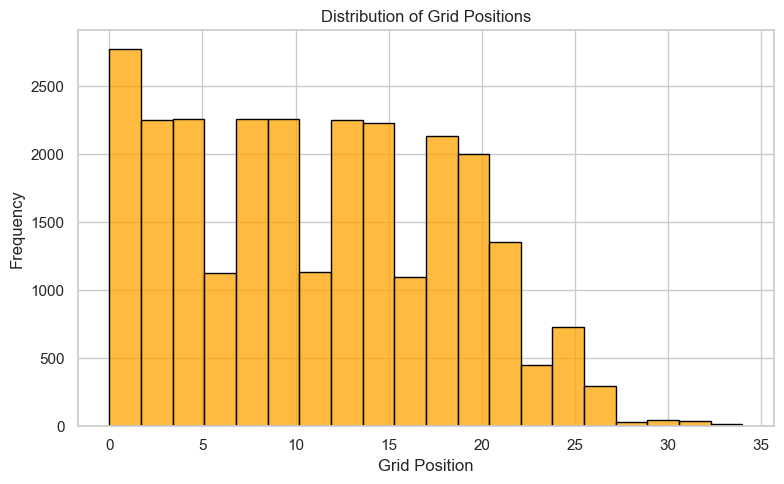

In [24]:
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['grid'], bins=20, kde=False, color='orange', edgecolor='black')
plt.title('Distribution of Grid Positions')
plt.xlabel('Grid Position')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

 <h4>Driver Win Count</h4>

In [18]:
top_winners = merged_df[merged_df['positionOrder'] == 1]['driverRef'].value_counts().head(10)
print("Top 10 Winning Drivers:\n", top_winners)

Top 10 Winning Drivers:
 driverRef
hamilton              105
michael_schumacher     91
max_verstappen         63
vettel                 53
prost                  51
senna                  41
alonso                 32
mansell                31
stewart                27
lauda                  25
Name: count, dtype: int64


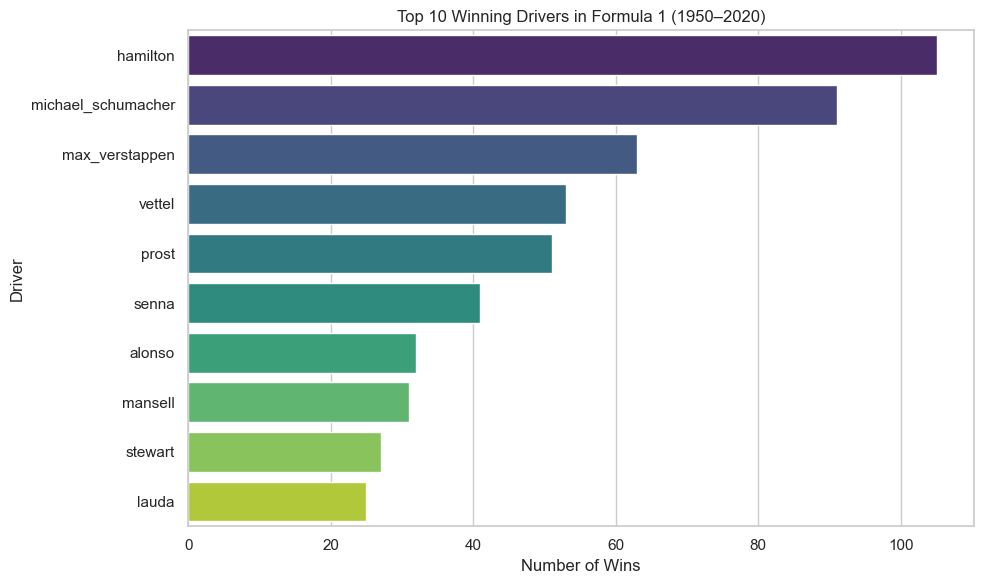

In [32]:
top_winning_drivers = (
    merged_df[merged_df['positionOrder'] == 1]['driverRef']
    .value_counts()
    .head(10)
    .reset_index()
)
top_winning_drivers.columns = ['driverRef', 'wins']

plt.figure(figsize=(10, 6))
sns.barplot(data=top_winning_drivers, x='wins', y='driverRef', palette='viridis')
plt.title('Top 10 Winning Drivers in Formula 1 (1950–2020)')
plt.xlabel('Number of Wins')
plt.ylabel('Driver')
plt.tight_layout()
plt.show()

- **Hamilton** holds the highest number of wins (105), establishing him as the most dominant driver in modern F1 history.
- **Michael Schumacher** remains a close second with 91 victories, representing a previous era of dominance.
- **Max Verstappen** has quickly climbed to third with 63 wins, highlighting his rapid rise in recent seasons.
- Other legends like **Vettel**, **Senna**, and **Alonso** maintain strong win records, reflecting sustained competitiveness across multiple seasons.
- The distribution shows a clear **concentration of wins among a few elite drivers**, which could introduce bias in predictive models if not addressed properly.

 <h4>Constructors’ Win Count</h4>

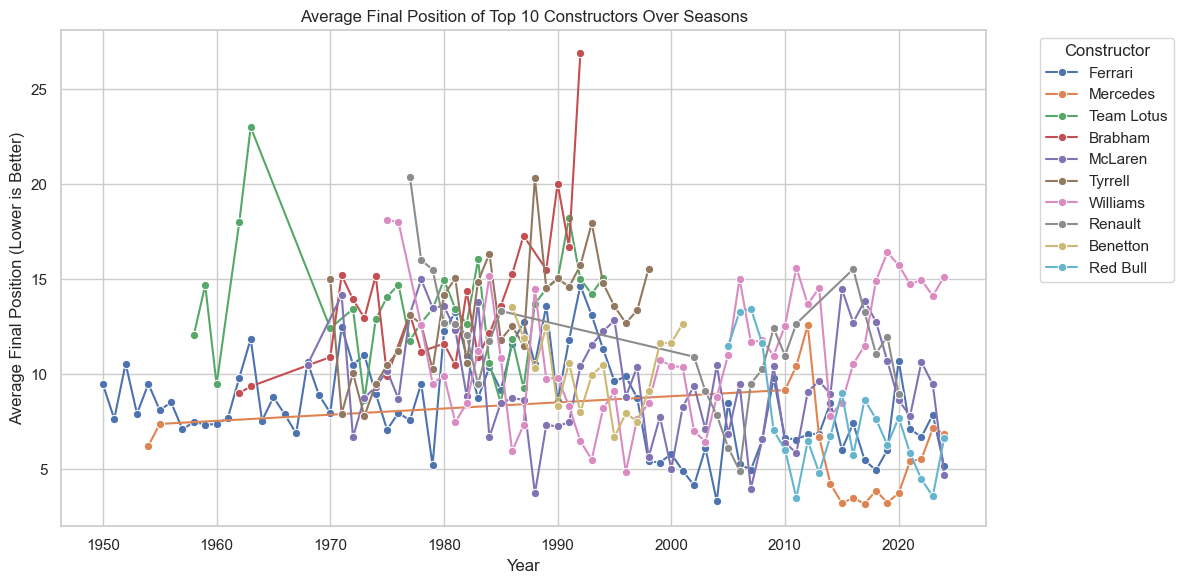

In [31]:
top_10_constructors = (
    merged_df[merged_df['positionOrder'] == 1]
    .groupby('constructor')['positionOrder']
    .count()
    .sort_values(ascending=False)
    .head(10)
    .index.tolist()
)


filtered_df = merged_df[merged_df['constructor'].isin(top_10_constructors)]

#Calculating average final position by year
avg_position_by_year = (
    filtered_df
    .groupby(['year', 'constructor'])['positionOrder']
    .mean()
    .reset_index()
)


plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_position_by_year, x='year', y='positionOrder', hue='constructor', marker='o')
plt.title('Average Final Position of Top 10 Constructors Over Seasons')
plt.ylabel('Average Final Position (Lower is Better)')
plt.xlabel('Year')
plt.legend(title='Constructor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


- **Ferrari** is historically the most dominant constructor in Formula 1 with **249 wins**.
- **McLaren**, **Mercedes**, and **Red Bull** follow — each having over **100 wins**, showing long-term performance and competitiveness.
- **Williams** is another strong historic performer, though less dominant in recent seasons.
- The bottom half of this top 10 includes teams that were more successful in the past but are either **defunct or less competitive now** (e.g., **Team Lotus**, **Benetton**, **Brabham**, **Tyrrell**).

 <h4>Lap Time Distribution </h4>

In [20]:
valid_laps = lap_times[lap_times['milliseconds'] > 0]
lap_time_stats = valid_laps['milliseconds'].describe()
print("Lap Time Stats:\n", lap_time_stats)

Lap Time Stats:
 count    5.890810e+05
mean     9.579945e+04
std      7.639973e+04
min      5.540400e+04
25%      8.204100e+04
50%      9.060800e+04
75%      1.019300e+05
max      7.507547e+06
Name: milliseconds, dtype: float64


 <h4>Pit Stop Frequency</h4>

In [23]:
pit_with_names = pit_stops.merge(drivers, on='driverId', how='left')
pit_count = pit_with_names.groupby('driverRef')['stop'].count().sort_values(ascending=False).head(10)
print("Top 10 Drivers by Pit Stops:\n", pit_count)

Top 10 Drivers by Pit Stops:
 driverRef
hamilton          557
perez             538
alonso            474
ricciardo         472
vettel            463
bottas            453
hulkenberg        388
max_verstappen    380
raikkonen         356
sainz             347
Name: stop, dtype: int64


Active drivers in pit lanes, which could be linked to aggressive strategy or reliability issues.

### Prediction Model

Evaluating a machine learning model that predicts whether a driver will finish in the Top 3 in a Formula 1 race.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, auc

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
base_path = '/Users/rad/Desktop/Useable Ai Project /Datasets/'

In [4]:
drivers = pd.read_csv(os.path.join(base_path, 'drivers.csv'))
constructors = pd.read_csv(os.path.join(base_path, 'constructors.csv'))
races = pd.read_csv(os.path.join(base_path, 'races.csv'))
results = pd.read_csv(os.path.join(base_path, 'results.csv'))
lap_times = pd.read_csv(os.path.join(base_path, 'lap_times.csv'))
pit_stops = pd.read_csv(os.path.join(base_path, 'pit_stops.csv'))
qualifying = pd.read_csv(os.path.join(base_path, 'qualifying.csv'))
circuits = pd.read_csv(os.path.join(base_path, 'circuits.csv'))

In [5]:
lap_times = lap_times[lap_times['milliseconds'] > 0].copy()
lap_times['milliseconds'] = lap_times['milliseconds'].astype(float)
pit_stops['duration'] = pd.to_numeric(pit_stops['duration'], errors='coerce')
pit_stops = pit_stops[pit_stops['duration'] > 0]

In [6]:
#Merging datasets
df = results.merge(races, on='raceId')
df = df.merge(drivers, on='driverId')
df = df.merge(constructors, on='constructorId')

In [7]:
pit_counts = pit_stops.groupby(['raceId', 'driverId']).size().reset_index(name='pit_stop_count')
avg_lap = lap_times.groupby(['raceId', 'driverId'])['milliseconds'].mean().reset_index(name='avg_lap_time')

In [8]:
df = df.merge(pit_counts, on=['raceId', 'driverId'], how='left')
df = df.merge(avg_lap, on=['raceId', 'driverId'], how='left')

In [9]:
df['pit_stop_count'].fillna(0, inplace=True)
df['avg_lap_time'].fillna(df['avg_lap_time'].mean(), inplace=True)

In [10]:
df['top_3'] = df['positionOrder'].apply(lambda x: 1 if x <= 3 else 0)

In [11]:
#Features for model
features = ['grid', 'pit_stop_count', 'avg_lap_time', 'constructorId']
X = df[features]
y = df['top_3']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [13]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['grid', 'pit_stop_count', 'avg_lap_time']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['constructorId'])
])

In [14]:
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

In [15]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['grid', 'pit_stop_count',
                                                   'avg_lap_time']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['constructorId'])])),
                ('smote', SMOTE(random_state=42)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [16]:
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

In [17]:
report = classification_report(y_test, y_pred, output_dict=True)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
roc_auc = roc_auc_score(y_test, y_proba)

In [18]:
report_df = pd.DataFrame(report).T
report_df.loc['1', 'pr_auc'] = pr_auc
report_df.loc['1', 'roc_auc'] = roc_auc

In [19]:
print("=== Classification Report (Top 3 Prediction) ===")
print(report_df)

=== Classification Report (Top 3 Prediction) ===
              precision    recall  f1-score      support   pr_auc   roc_auc
0              0.952169  0.869035  0.908704  4673.000000      NaN       NaN
1              0.436983  0.699558  0.537939   679.000000  0.51829  0.874299
accuracy       0.847534  0.847534  0.847534     0.847534      NaN       NaN
macro avg      0.694576  0.784297  0.723322  5352.000000      NaN       NaN
weighted avg   0.886808  0.847534  0.861666  5352.000000      NaN       NaN


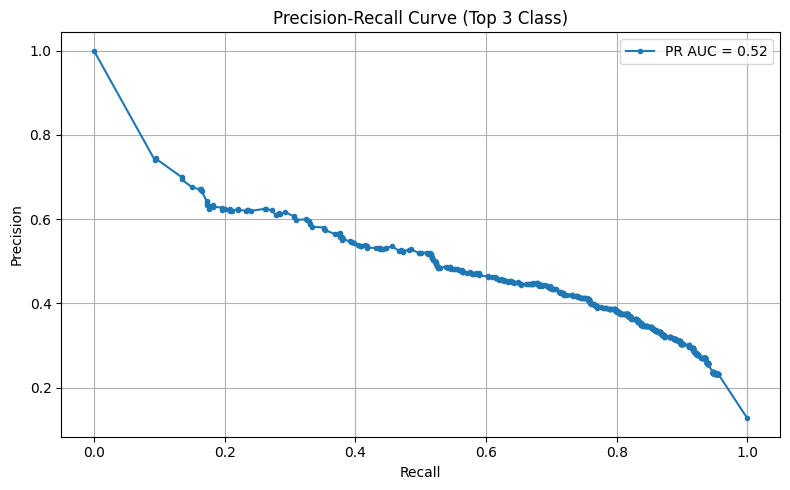

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Top 3 Class)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The Precision-Recall curve shows that the model is decent at predicting Top 3 finishers, with a PR AUC of 0.52. When it’s really confident about a podium prediction, it’s usually right — but it misses a lot of actual podiums in the process. As the model tries to find more of them, it starts making more mistakes. So right now, it's better at spotting strong contenders than it is at catching all possible podium finishers. To make it more useful, I plan to add more context like qualifying positions and driver performance trends, try models like XGBoost, and experiment with the prediction threshold to strike a better balance between accuracy and coverage.

##  F1 Top-3 Prediction Pipeline: Enhancements & Evaluation

This part of the code implements a refined machine learning pipeline to predict whether a Formula 1 driver will finish in the **Top 3** using race data, performance metrics, and driver-specific features. The following improvements were made based on instructor recommendations:

---

### New Features
- **Qualifying Position (`position`)**: Starting position from qualifying session, a strong predictor of race outcome.
- **Driver Skill (`driver_skill`)**: Average finishing position of the driver across all races.

---

### Class Imbalance Handling
- **SMOTE**: Oversampling the minority class (Top 3) to balance training data.
- **XGBoost**: Gradient boosting model known for handling imbalanced datasets well.
- **Class Weighting (`scale_pos_weight`)**: Adjusted using the ratio of negative to positive samples.

---

### Threshold Tuning
- **Custom decision threshold = 0.6** instead of default 0.5
- Improves **precision** at the cost of some recall, to reduce false positives.

---

### Time-Aware Train/Test Split
- Data is split chronologically based on race date to simulate real-world deployment.
- Ensures no data leakage from future races.

---

### Evaluation Metrics
- **Classification Report**:
  - Precision, Recall, F1-score per class
  - Macro and weighted averages
- **PR AUC**: Precision-Recall Area


In [21]:
!pip install imbalanced-learn shap xgboost --quiet


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [22]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap

In [24]:
base_path = '/Users/rad/Desktop/Useable Ai Project /Datasets/'
drivers = pd.read_csv(os.path.join(base_path, 'drivers.csv'))
constructors = pd.read_csv(os.path.join(base_path, 'constructors.csv'))
races = pd.read_csv(os.path.join(base_path, 'races.csv'))
results = pd.read_csv(os.path.join(base_path, 'results.csv'))
lap_times = pd.read_csv(os.path.join(base_path, 'lap_times.csv'))
pit_stops = pd.read_csv(os.path.join(base_path, 'pit_stops.csv'))
qualifying = pd.read_csv(os.path.join(base_path, 'qualifying.csv'))

In [25]:
# Cleaning lap & pit data
lap_times = lap_times[lap_times['milliseconds'] > 0].copy()
lap_times['milliseconds'] = lap_times['milliseconds'].astype(float)
pit_stops['duration'] = pd.to_numeric(pit_stops['duration'], errors='coerce')
pit_stops = pit_stops[pit_stops['duration'] > 0]

In [27]:
# Merging base data
df = results.merge(races, on='raceId')
df = df.merge(drivers, on='driverId')
df = df.merge(constructors, on='constructorId')
df = df.merge(qualifying[['raceId', 'driverId', 'position']], on=['raceId', 'driverId'], how='left')  # Qualifying position

# Add pit stop count & avg lap time
pit_counts = pit_stops.groupby(['raceId', 'driverId']).size().reset_index(name='pit_stop_count')
avg_lap = lap_times.groupby(['raceId', 'driverId'])['milliseconds'].mean().reset_index(name='avg_lap_time')
df = df.merge(pit_counts, on=['raceId', 'driverId'], how='left')
df = df.merge(avg_lap, on=['raceId', 'driverId'], how='left')

In [29]:
# Filling missing values
df['pit_stop_count'].fillna(0, inplace=True)
df['avg_lap_time'].fillna(df['avg_lap_time'].mean(), inplace=True)

In [30]:
# Creating driver_skill feature
driver_skill = df.groupby('driverId')['positionOrder'].mean().reset_index(name='driver_skill')
df = df.merge(driver_skill, on='driverId', how='left')

In [31]:
# Creating label
df['top_3'] = df['positionOrder'].apply(lambda x: 1 if x <= 3 else 0)

In [32]:
# Creating a time-aware train-test split
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
cutoff_date = df['date'].quantile(0.8)
train_df = df[df['date'] <= cutoff_date]
test_df = df[df['date'] > cutoff_date]

In [34]:
# Defining features
features = ['grid', 'pit_stop_count', 'avg_lap_time', 'constructorId', 'driver_skill']
X_train = train_df[features]
y_train = train_df['top_3']
X_test = test_df[features]
y_test = test_df['top_3']

In [38]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['grid', 'pit_stop_count', 'avg_lap_time', 'driver_skill']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['constructorId'])
])

In [39]:
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42))
])

In [40]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['grid', 'pit_stop_count',
                                                   'avg_lap_time',
                                                   'driver_skill']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['constructorId'])])),
                ('smote', SMOTE(random_state=42)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [41]:
# Predicting with threshold tuning
y_proba = pipeline.predict_proba(X_test)[:, 1]
threshold = 0.6
y_pred = (y_proba >= threshold).astype(int)

In [42]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
roc_auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df.loc['1', 'pr_auc'] = pr_auc
report_df.loc['1', 'roc_auc'] = roc_auc

In [43]:
print("=== Classification Report (Top 3 Prediction) ===")
print(report_df)

=== Classification Report (Top 3 Prediction) ===
              precision    recall  f1-score      support    pr_auc   roc_auc
0              0.974752  0.711965  0.822888  4555.000000       NaN       NaN
1              0.345636  0.891892  0.498203   777.000000  0.637578  0.898095
accuracy       0.738185  0.738185  0.738185     0.738185       NaN       NaN
macro avg      0.660194  0.801928  0.660545  5332.000000       NaN       NaN
weighted avg   0.883075  0.738185  0.775573  5332.000000       NaN       NaN


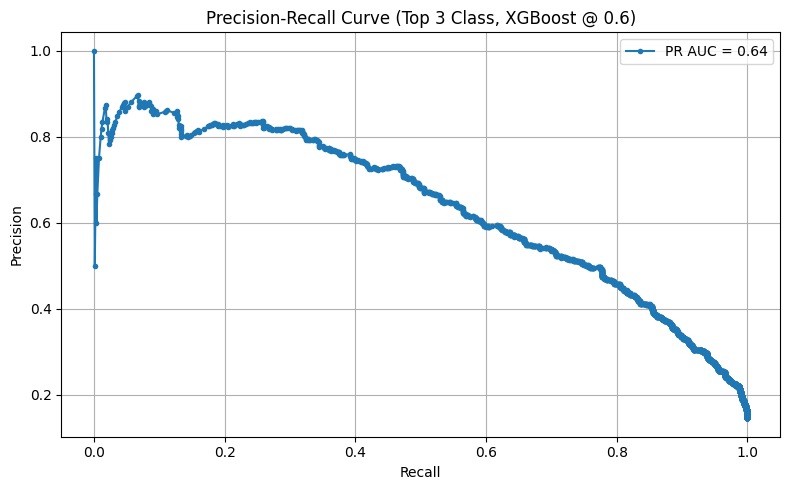

In [44]:
# PR Curve
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Top 3 Class, XGBoost @ 0.6)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### The code block is using SHAP (SHapley Additive exPlanations) to interpret the trained machine learning model's predictions

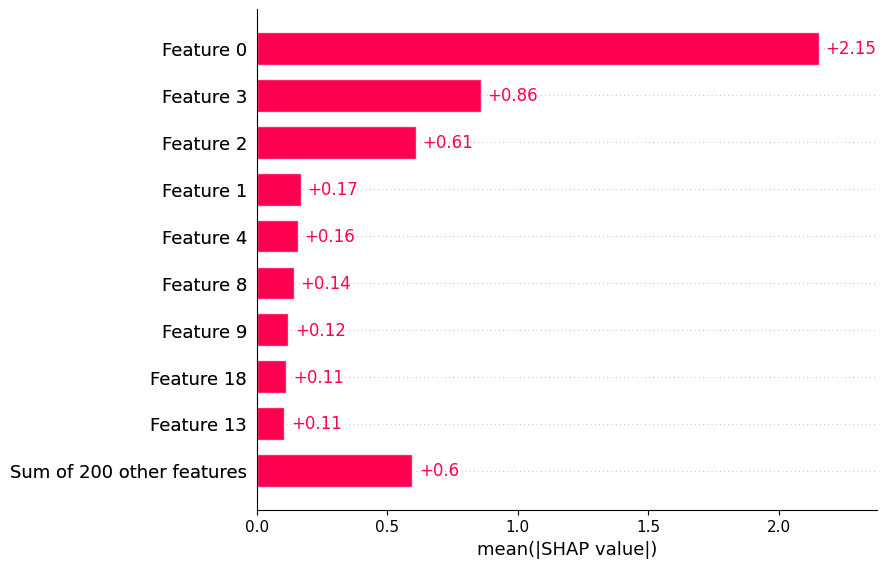

In [45]:
# SHAP Explainability
explainer = shap.Explainer(pipeline.named_steps['clf'])
X_transformed = pipeline.named_steps['preprocessor'].transform(X_test)
shap_values = explainer(X_transformed)
shap.plots.bar(shap_values, max_display=10)

The SHAP summary plot shows that the model’s predictions are heavily influenced by just a few key features, with Feature 0 having the strongest impact (average SHAP value of +2.15), likely representing something like grid or qualifying position. Feature 3 and Feature 2 also contribute meaningfully (+0.86 and +0.61), while the remaining features have much smaller average impacts (below +0.2). This suggests the model relies mainly on 3–4 important inputs, while the many other features—such as one-hot encoded team or constructor IDs—have only minor influence individually.

### Final Rank Prediction Model

This is a regression model to predict the exact final finishing position (positionOrder) of F1 drivers in a race and then using those predictions to rank all drivers in each race.

In [46]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
base_path = '/Users/rad/Desktop/Useable Ai Project /Datasets/'
drivers = pd.read_csv(os.path.join(base_path, 'drivers.csv'))
constructors = pd.read_csv(os.path.join(base_path, 'constructors.csv'))
races = pd.read_csv(os.path.join(base_path, 'races.csv'))
results = pd.read_csv(os.path.join(base_path, 'results.csv'))
lap_times = pd.read_csv(os.path.join(base_path, 'lap_times.csv'))
pit_stops = pd.read_csv(os.path.join(base_path, 'pit_stops.csv'))
qualifying = pd.read_csv(os.path.join(base_path, 'qualifying.csv'))

In [49]:
lap_times = lap_times[lap_times['milliseconds'] > 0].copy()
lap_times['milliseconds'] = lap_times['milliseconds'].astype(float)
pit_stops['duration'] = pd.to_numeric(pit_stops['duration'], errors='coerce')
pit_stops = pit_stops[pit_stops['duration'] > 0]

In [50]:
df = results.merge(races, on='raceId')
df = df.merge(drivers, on='driverId')
df = df.merge(constructors, on='constructorId')

In [51]:
qual_pos = qualifying[['raceId', 'driverId', 'position']].rename(columns={'position': 'qualifyPosition'})
df = df.merge(qual_pos, on=['raceId', 'driverId'], how='left')
df['qualifyPosition'].fillna(df['grid'], inplace=True)

In [52]:
# Pit stop count & average lap time
pit_counts = pit_stops.groupby(['raceId', 'driverId']).size().reset_index(name='pit_stop_count')
avg_lap = lap_times.groupby(['raceId', 'driverId'])['milliseconds'].mean().reset_index(name='avg_lap_time')
df = df.merge(pit_counts, on=['raceId', 'driverId'], how='left')
df = df.merge(avg_lap, on=['raceId', 'driverId'], how='left')
df['pit_stop_count'].fillna(0, inplace=True)
df['avg_lap_time'].fillna(df['avg_lap_time'].mean(), inplace=True)

In [53]:
# Driver skill = avg finish across all races
driver_skill = df.groupby('driverId')['positionOrder'].mean().reset_index(name='driver_skill')
df = df.merge(driver_skill, on='driverId', how='left')

In [54]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
cutoff = df['date'].quantile(0.8)
train_df = df[df['date'] <= cutoff]
test_df = df[df['date'] > cutoff]

In [55]:
features = ['grid', 'pit_stop_count', 'avg_lap_time', 'qualifyPosition', 'constructorId', 'driver_skill']
X_train = train_df[features]
y_train = train_df['positionOrder']
X_test = test_df[features]
y_test = test_df['positionOrder']

In [56]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['grid', 'pit_stop_count', 'avg_lap_time', 'qualifyPosition', 'driver_skill']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['constructorId'])
])

In [57]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

In [58]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

### For a specific race, sorting all drivers by predicted finishing position, effectively ranking them.
This code is building a regression model to predict the exact final finishing position (positionOrder) of F1 drivers in a race and then using those predictions to rank all drivers in each race.

In [62]:
# Adding raceId and driver name back to test set for ranking
X_test_with_meta = test_df[['raceId', 'driverId']].copy()
X_test_with_meta['actual_position'] = y_test
X_test_with_meta['predicted_position'] = y_pred

In [64]:
#include driver name and race details
X_test_with_meta = X_test_with_meta.merge(drivers[['driverId', 'surname']], on='driverId', how='left')
X_test_with_meta = X_test_with_meta.merge(races[['raceId', 'year', 'name']], on='raceId', how='left')

In [65]:
ranked_races = X_test_with_meta.copy()
ranked_races['predicted_rank'] = ranked_races.groupby('raceId')['predicted_position'].rank(method='first')

In [66]:
example_race = ranked_races[ranked_races['name'].str.contains('Monaco', case=False)].sort_values(by='predicted_rank')

In [69]:
print("Predicted Finishing Order (Monaco GP):")
print(example_race[['year', 'name', 'surname', 'predicted_position', 'predicted_rank', 'actual_position']])

Predicted Finishing Order (Monaco GP):
      year               name    surname  predicted_position  predicted_rank  \
410   2013  Monaco Grand Prix   Hamilton            7.454942             1.0   
1613  2016  Monaco Grand Prix     Vettel            4.546348             1.0   
2467  2018  Monaco Grand Prix     Vettel            2.397768             1.0   
3631  2021  Monaco Grand Prix      Sainz            5.245715             1.0   
4525  2023  Monaco Grand Prix     Alonso            4.258289             1.0   
...    ...                ...        ...                 ...             ...   
402   2013  Monaco Grand Prix    Bianchi           16.550753            21.0   
817   2014  Monaco Grand Prix  Maldonado           16.187111            21.0   
833   2014  Monaco Grand Prix    Bianchi           16.859501            22.0   
1606  2016  Monaco Grand Prix       Nasr           22.710289            22.0   
399   2013  Monaco Grand Prix        Pic           17.336912            22.0   



In [59]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [60]:
print(" Final Rank Prediction Performance:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2  : {r2:.2f}")

 Final Rank Prediction Performance:
MAE : 3.79
RMSE: 4.76
R2  : 0.37


### Final Rank Prediction Metrics

- **MAE (Mean Absolute Error) = 3.79**  
  → On average, the model's predicted finishing position is about **3.8 places off** from the actual result.

- **RMSE (Root Mean Squared Error) = 4.76**  
  → Indicates the **average error magnitude**, penalizing larger mistakes. A few predictions are off by **5+ positions**.

- **R² Score = 0.37**  
  → The model explains **37% of the variance** in finishing positions. This means the model captures **some useful patterns**, but a lot of race outcome variability is still unexplained.

### This is how we can improve :
Add track-specific features: street vs. permanent circuits, overtaking difficulty

Add session-specific context: laps, safety car presence, penalties

Try a sequence-based model (e.g., time-aware gradient boosting or LSTMs)

Predict ranking within clusters (e.g., Top 5, Midfield, Bottom)

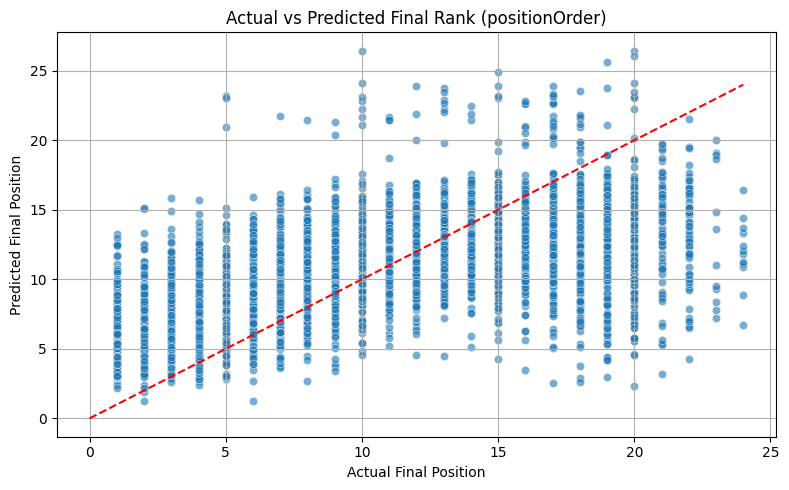

In [61]:
# Visualize actual vs predicted ranks
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], '--', color='red')
plt.xlabel("Actual Final Position")
plt.ylabel("Predicted Final Position")
plt.title("Actual vs Predicted Final Rank (positionOrder)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Actual vs Predicted Final Position
The red dashed line is the ideal case: where the predicted position exactly matches the actual one.

Your points generally follow the diagonal trend, meaning the model understands relative race order to some degree.

However, there's visible vertical spread, especially for mid-field positions (around P10–P15), which means:

Drivers who actually finish 10th are often predicted between 5th and 18th.

The model has more variance and uncertainty in mid-pack predictions.

### Track Performance Shift Season-over-Season for each driver

In [70]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [71]:
base_path = '/Users/rad/Desktop/Useable Ai Project /Datasets/'
drivers = pd.read_csv(os.path.join(base_path, 'drivers.csv'))
results = pd.read_csv(os.path.join(base_path, 'results.csv'))
races = pd.read_csv(os.path.join(base_path, 'races.csv'))

In [72]:
# Merging results with race data for date and year
df = results.merge(races[['raceId', 'year']], on='raceId')

In [73]:
# Calculating average finishing position (positionOrder) per driver per year
driver_year_avg = df.groupby(['driverId', 'year'])['positionOrder'].mean().reset_index()
driver_year_avg = driver_year_avg.sort_values(['driverId', 'year'])

In [74]:
# Computing season-to-season delta (shift in average finish)
driver_year_avg['performance_shift'] = driver_year_avg.groupby('driverId')['positionOrder'].diff(-1)

In [76]:
driver_year_avg = driver_year_avg.merge(drivers[['driverId', 'surname']], on='driverId', how='left')

In [78]:
top_drivers = driver_year_avg['driverId'].value_counts().head(5).index.tolist()

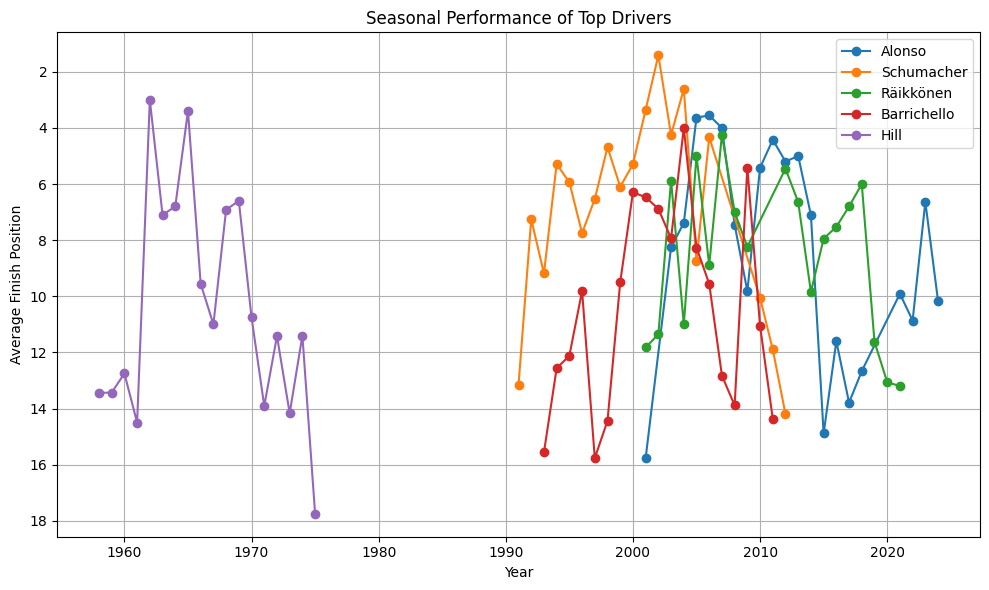

In [79]:
plt.figure(figsize=(10, 6))
for driver_id in top_drivers:
    d = driver_year_avg[driver_year_avg['driverId'] == driver_id]
    plt.plot(d['year'], d['positionOrder'], marker='o', label=d['surname'].values[0])
plt.gca().invert_yaxis()
plt.xlabel("Year")
plt.ylabel("Average Finish Position")
plt.title("Seasonal Performance of Top Drivers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
#Clustering drivers based on finish trends using KMeans
pivot = driver_year_avg.pivot(index='driverId', columns='year', values='positionOrder')
pivot = pivot.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
pivot = pivot.dropna()

scaler = StandardScaler()
pivot_scaled = scaler.fit_transform(pivot)

In [83]:
kmeans = KMeans(n_clusters=3, random_state=42)
pivot['cluster'] = kmeans.fit_predict(pivot_scaled)

# Join back names
pivot = pivot.merge(drivers[['driverId', 'surname']], on='driverId', how='left')

# Show cluster summary
for cluster in range(3):
    members = pivot[pivot['cluster'] == cluster]['surname'].tolist()
    print(f"\n Cluster {cluster} — {len(members)} drivers:\n", members)


 Cluster 0 — 330 drivers:
 ['Hamilton', 'Heidfeld', 'Rosberg', 'Alonso', 'Kovalainen', 'Nakajima', 'Bourdais', 'Räikkönen', 'Kubica', 'Glock', 'Sato', 'Piquet Jr.', 'Massa', 'Coulthard', 'Trulli', 'Webber', 'Button', 'Vettel', 'Fisichella', 'Barrichello', 'Schumacher', 'Liuzzi', 'Wurz', 'Schumacher', 'Pablo Montoya', 'Monteiro', 'Villeneuve', 'Pizzonia', 'da Matta', 'Panis', 'Baumgartner', 'Gené', 'Frentzen', 'Verstappen', 'Firman', 'Kiesa', 'Burti', 'Alesi', 'Irvine', 'Häkkinen', 'Salo', 'Buemi', 'Zanardi', 'Nakano', 'Magnussen', 'Berger', 'Fontana', 'Brundle', 'Blundell', 'Boullion', 'Bernard', 'Dalmas', 'Prost', 'Patrese', 'Boutsen', 'Suzuki', 'Piquet', 'Donnelly', 'Kobayashi', 'Palmer', 'Laffite', 'de Angelis', 'Dumfries', 'Lauda', 'Bellof', 'Watson', 'Reutemann', 'Mass', 'Borgudd', 'Pironi', 'Zunino', 'Scheckter', 'Regazzoni', 'Fittipaldi', 'Hunt', 'Ickx', 'Peterson', 'Pace', 'Pryce', 'Nilsson', 'Oliver', 'Takahashi', 'Hoshino', 'Brown', 'Hasemi', 'Donohue', 'Tunmer', 'Keizan', '

### What the Clusters Reveal (KMeans on Driver Performance)

- **Cluster 0 (330 drivers)**  
   Contains some of the **most iconic and successful drivers**:  
  *Hamilton, Verstappen, Vettel, Alonso, Schumacher, Rosberg, Button, Räikkönen, Leclerc, Senna*  
  ➤ These are drivers who **frequently finished in top positions** over multiple seasons.

- **Cluster 1 (446 drivers)**  
   Likely includes **midfield drivers** with fluctuating results. Examples:  
  *Bottas, Gasly, Magnussen, Hülkenberg, Sainz, Grosjean, Perez, Norris, Ocon, Albon*  
  ➤ Drivers in this group tend to have **inconsistent performance or are limited by team dynamics**.

- **Cluster 2 (166 drivers)**  
   This group contains mostly **backmarkers or part-time/inexperienced drivers**:  
  *Latifi, Sirotkin, Ide, Karthikeyan, Chandhok, Maldonado, Mazepin*  
  ➤ These drivers **consistently finished near the back** of the grid or **did not race full seasons**.
